# Logistic regression Assumptions

- log-odds linearity
- multicollinearity
- outliers


## Data Loading


In [6]:
import pandas as pd
import numpy as np
import math
import matplotlib.pyplot as plt
import json

from python_proj.utils.util import safe_save_fig, Counter
import python_proj.utils.exp_utils as exp_utils

file_name = "dataset_transformed"
base_path = exp_utils.BASE_PATH
data_path = f'{base_path}/final_data/{file_name}.csv'
figure_base_path = f"{base_path}/figures/{file_name}/collaborative/"

# Meta stuff.
pr_merged_key = 'PullRequestIsMerged'
ftc_key = 'SubmitterIsFirstTimeContributor'
seed_counter = Counter()


# Loads regular dataframe.
df: pd.DataFrame = pd.read_csv(filepath_or_buffer=data_path, header=0)
if 'Unnamed: 1' in df.columns:
    df = df.drop(['Unnamed: 1', "Project Name.1"], axis=1)
print(df.columns)

# Loads first-time contributor data frame.
print(f'{len(df)=}')

# Creates sub-datasets.
metadata_fields = ['ID', 'Project Name',
                   'Submitter ID', 'PR Number', 'Closed At']
dependent_fields = [pr_merged_key]
independent_fields = [field for field in df.columns
                      if (field not in metadata_fields
                          and field not in dependent_fields)]

df[independent_fields].describe()


Index(['ID', 'Project Name', 'Submitter ID', 'PR Number', 'Closed At',
       'PullRequestIsMerged', 'ControlIntegratedBySameUser',
       'ControlPullRequestHasComments',
       'ControlPullRequestHasCommentByExternalUser',
       'ControlHasHashTagInDescription',
       'IntraProjectSubmitterPullRequestSuccessRate',
       'EcosystemExperienceSubmitterPullRequestSuccessRate',
       'DependencyEcosystemExperienceSubmitterPullRequestSuccessRate',
       'NonDependencyEcosystemExperienceSubmitterPullRequestSuccessRate',
       'InversedDependencyEcosystemExperienceSubmitterPullRequestSuccessRate',
       'SubmitterIsFirstTimeContributor',
       'ln(1 + ControlPullRequestLifeTimeInMinutes)',
       'ln(1 + ControlNumberOfCommitsInPullRequest)',
       'ln(1 + ControlIntraProjectPullRequestExperienceOfIntegrator)',
       'ln(1 + IntraProjectSubmitterPullRequestSubmissionCount)',
       'ln(1 + IntraProjectSubmitterPullRequestCommentCount)',
       'ln(1 + IntraProjectSharedExperiencePu

,IntraProjectSubmitterPullRequestSuccessRate,EcosystemExperienceSubmitterPullRequestSuccessRate,DependencyEcosystemExperienceSubmitterPullRequestSuccessRate,NonDependencyEcosystemExperienceSubmitterPullRequestSuccessRate,InversedDependencyEcosystemExperienceSubmitterPullRequestSuccessRate,ln(1 + ControlPullRequestLifeTimeInMinutes),ln(1 + ControlNumberOfCommitsInPullRequest),ln(1 + ControlIntraProjectPullRequestExperienceOfIntegrator),ln(1 + IntraProjectSubmitterPullRequestSubmissionCount),ln(1 + IntraProjectSubmitterPullRequestCommentCount),...,ln(1 + InversedDependencyEcosystemExperienceSubmitterIssueSubmissionCount),ln(1 + InversedDependencyEcosystemExperienceSubmitterIssueCommentCount),ln(1 + WeightedEcosystemSecondOrderInDegreeCentrality),ln(1 + WeightedEcosystemSecondOrderOutDegreeCentrality),ln(1 + WeightedIntraProjectSecondOrderInDegreeCentrality),ln(1 + WeightedIntraProjectSecondOrderOutDegreeCentrality),ln(1 + EcosystemIntegratorToSubmitterLinkIntensity),ln(1 + EcosystemSubmitterToIntegratorLinkIntensity),ln(1 + IntraProjectIntegratorToSubmitterLinkIntensity),ln(1 + IntraProjectSubmitterToIntegratorLinkIntensity)
count,1.216221e+06,1.216221e+06,1.216221e+06,1.216221e+06,1.216221e+06,1.216221e+06,1.216221e+06,1.216221e+06,1.216221e+06,1.216221e+06,...,1.216221e+06,1.216221e+06,1.216221e+06,1.216221e+06,1.216221e+06,1.216221e+06,1.216221e+06,1.216221e+06,1.216221e+06,1.216221e+06
mean,5.027950e-01,4.028468e-01,9.859457e-02,3.751558e-01,5.921727e-02,4.195870e-01,1.184307e-01,2.984181e-01,1.687675e-01,1.420724e-01,...,9.537892e-03,1.753143e-02,5.184194e-02,4.184437e-02,4.874358e-02,4.224923e-02,4.721868e-02,5.028227e-02,5.627708e-02,7.173808e-02
std,4.710790e-01,4.523912e-01,2.907958e-01,4.479800e-01,2.284907e-01,2.256942e-01,7.152478e-02,1.867575e-01,1.841873e-01,1.855131e-01,...,5.259800e-02,8.246395e-02,8.803506e-02,8.230781e-02,9.031063e-02,8.361355e-02,1.028680e-01,1.043392e-01,1.113767e-01,1.174610e-01
min,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,...,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00
25%,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,2.366019e-01,7.525668e-02,1.658140e-01,0.000000e+00,0.000000e+00,...,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00
50%,6.666667e-01,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,4.433628e-01,7.525668e-02,2.972185e-01,9.315576e-02,0.000000e+00,...,0.000000e+00,0.000000e+00,4.480431e-03,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00
75%,1.000000e+00,9.393939e-01,0.000000e+00,9.230769e-01,0.000000e+00,5.863080e-01,1.505134e-01,4.381968e-01,3.094567e-01,2.738495e-01,...,0.000000e+00,0.000000e+00,7.179541e-02,4.785956e-02,5.936040e-02,4.587383e-02,2.909834e-02,5.172123e-02,6.458231e-02,1.096827e-01
max,1.000000e+00,1.000000e+00,1.000000e+00,1.000000e+00,1.000000e+00,1.000000e+00,1.000000e+00,1.000000e+00,1.000000e+00,1.000000e+00,...,1.000000e+00,1.000000e+00,1.000000e+00,1.000000e+00,1.000000e+00,1.000000e+00,1.000000e+00,1.000000e+00,1.000000e+00,1.000000e+00


In [7]:
# Drops all ecosystem fields.

from python_proj.utils.util import get_matching

has_eco_but_no_collab_pattern = (
    r"^(?!.*(?:LinkIntensity|DegreeCentrality))(?=.*Ecosystem).*"
)
dropped_fields = list(get_matching(independent_fields, has_eco_but_no_collab_pattern))
print(f"{len(dropped_fields)=}")
print(f"{dropped_fields=}")

df = df.drop(dropped_fields, axis=1)
independent_fields = [
    field for field in independent_fields if field not in dropped_fields
]

df.describe()

len(dropped_fields)=22
dropped_fields=['EcosystemExperienceSubmitterPullRequestSuccessRate', 'DependencyEcosystemExperienceSubmitterPullRequestSuccessRate', 'NonDependencyEcosystemExperienceSubmitterPullRequestSuccessRate', 'InversedDependencyEcosystemExperienceSubmitterPullRequestSuccessRate', 'ln(1 + EcosystemSharedExperiencePullRequestSubmittedByIntegratorIntegratedBySubmitter)', 'ln(1 + EcosystemSharedExperiencePullRequestSubmittedByIntegratorCommentedOnBySubmitter.1)', 'ln(1 + EcosystemExperienceSubmitterPullRequestSubmissionCount)', 'ln(1 + EcosystemExperienceSubmitterPullRequestCommentCount)', 'ln(1 + DependencyEcosystemExperienceSubmitterPullRequestSubmissionCount)', 'ln(1 + DependencyEcosystemExperienceSubmitterPullRequestCommentCount)', 'ln(1 + NonDependencyEcosystemExperienceSubmitterPullRequestSubmissionCount)', 'ln(1 + NonDependencyEcosystemExperienceSubmitterPullRequestCommentCount)', 'ln(1 + InversedDependencyEcosystemExperienceSubmitterPullRequestSubmissionCount)', 'ln(

,ID,Submitter ID,PR Number,IntraProjectSubmitterPullRequestSuccessRate,ln(1 + ControlPullRequestLifeTimeInMinutes),ln(1 + ControlNumberOfCommitsInPullRequest),ln(1 + ControlIntraProjectPullRequestExperienceOfIntegrator),ln(1 + IntraProjectSubmitterPullRequestSubmissionCount),ln(1 + IntraProjectSubmitterPullRequestCommentCount),ln(1 + IntraProjectSharedExperiencePullRequestSubmittedBySubmitterIntegratedByIntegrator),...,ln(1 + IntraProjectSubmitterIssueSubmissionCount),ln(1 + IntraProjectSubmitterIssueCommentCount),ln(1 + WeightedEcosystemSecondOrderInDegreeCentrality),ln(1 + WeightedEcosystemSecondOrderOutDegreeCentrality),ln(1 + WeightedIntraProjectSecondOrderInDegreeCentrality),ln(1 + WeightedIntraProjectSecondOrderOutDegreeCentrality),ln(1 + EcosystemIntegratorToSubmitterLinkIntensity),ln(1 + EcosystemSubmitterToIntegratorLinkIntensity),ln(1 + IntraProjectIntegratorToSubmitterLinkIntensity),ln(1 + IntraProjectSubmitterToIntegratorLinkIntensity)
count,1.216221e+06,1.216221e+06,1.216221e+06,1.216221e+06,1.216221e+06,1.216221e+06,1.216221e+06,1.216221e+06,1.216221e+06,1.216221e+06,...,1.216221e+06,1.216221e+06,1.216221e+06,1.216221e+06,1.216221e+06,1.216221e+06,1.216221e+06,1.216221e+06,1.216221e+06,1.216221e+06
mean,1.473143e+08,5.093466e+06,8.082764e+02,5.027950e-01,4.195870e-01,1.184307e-01,2.984181e-01,1.687675e-01,1.420724e-01,1.435823e-01,...,7.006013e-02,1.272642e-01,5.184194e-02,4.184437e-02,4.874358e-02,4.224923e-02,4.721868e-02,5.028227e-02,5.627708e-02,7.173808e-02
std,9.953631e+07,7.967840e+06,2.296849e+03,4.710790e-01,2.256942e-01,7.152478e-02,1.867575e-01,1.841873e-01,1.855131e-01,1.737207e-01,...,1.280338e-01,1.877090e-01,8.803506e-02,8.230781e-02,9.031063e-02,8.361355e-02,1.028680e-01,1.043392e-01,1.113767e-01,1.174610e-01
min,6.870000e+02,1.000000e+00,1.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,...,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00
25%,5.925868e+07,4.673300e+05,5.000000e+01,0.000000e+00,2.366019e-01,7.525668e-02,1.658140e-01,0.000000e+00,0.000000e+00,0.000000e+00,...,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00
50%,1.367237e+08,1.634092e+06,1.990000e+02,6.666667e-01,4.433628e-01,7.525668e-02,2.972185e-01,9.315576e-02,0.000000e+00,9.315576e-02,...,0.000000e+00,0.000000e+00,4.480431e-03,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00
75%,2.260987e+08,6.254382e+06,6.840000e+02,1.000000e+00,5.863080e-01,1.505134e-01,4.381968e-01,3.094567e-01,2.738495e-01,2.615213e-01,...,1.045989e-01,2.261884e-01,7.179541e-02,4.785956e-02,5.936040e-02,4.587383e-02,2.909834e-02,5.172123e-02,6.458231e-02,1.096827e-01
max,3.617734e+08,5.973444e+07,8.297600e+04,1.000000e+00,1.000000e+00,1.000000e+00,1.000000e+00,1.000000e+00,1.000000e+00,1.000000e+00,...,1.000000e+00,1.000000e+00,1.000000e+00,1.000000e+00,1.000000e+00,1.000000e+00,1.000000e+00,1.000000e+00,1.000000e+00,1.000000e+00


## Log-odds linearity


### Visual checking


untransformed
IntraProjectSubmitterPullRequestSuccessRate:
0.00    0.000000
0.10    0.500000
0.25    0.862069
0.40    0.954545
0.50    1.000000
0.60    1.000000
0.75    1.000000
0.90    1.000000
1.00    1.000000
Name: IntraProjectSubmitterPullRequestSuccessRate, dtype: float64

x=[0.0, 0.75, 0.9166666666666666, 1.0, 1.0, 1.0, 1.0, 1.0], y=[0.0864560959635069, 1.612908344969674, 2.561179719489756, 2.5568842641654532, 2.4950778699100717, 2.4950778699100717, 2.4950778699100717, 2.4950778699100717]
ln(1 + ControlPullRequestLifeTimeInMinutes):
0.00    0.001063
0.25    0.236602
0.50    0.443367
0.75    0.586309
1.00    1.000000
Name: ln(1 + ControlPullRequestLifeTimeInMinutes), dtype: float64

x=[0.1276352536011394, 0.3399618999347039, 0.5095672169017281, 0.6888936548806874], y=[1.8974125093742842, 1.9034566572668266, 1.603812550447277, 0.3070368088340966]
ln(1 + ControlNumberOfCommitsInPullRequest):
0.00    0.075257
0.25    0.075257
0.50    0.075257
0.75    0.150513
1.00    1.000000
Name: 

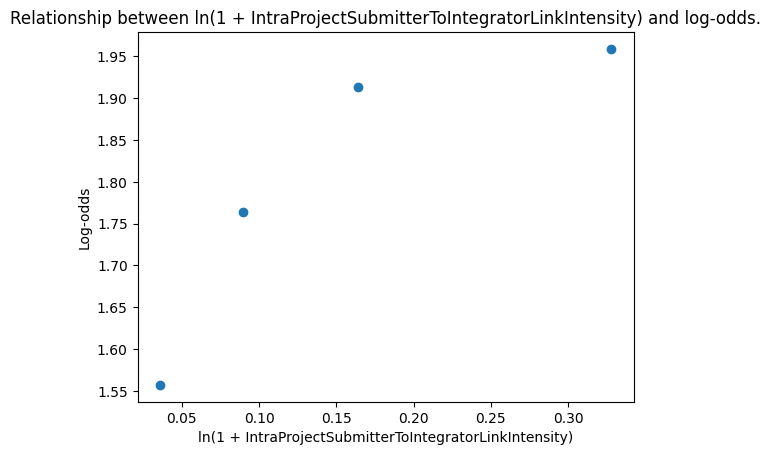

In [8]:
import regex as re
from numbers import Number
from typing import Callable, Iterator
import numpy as np
from python_proj.utils.util import tuple_chain


def test_log_linearity(
    independents: pd.DataFrame,
    dependent: pd.Series,
    transform_title: str = ""
):
    continuous_fields = independents.select_dtypes(include='number')

    all_data = pd.DataFrame()
    all_data[continuous_fields.columns] = continuous_fields.copy()
    all_data[pr_merged_key] = dependent.copy()

    for field in continuous_fields.columns:
        # Creates copy of the relevant fields.
        included = pd.DataFrame()
        included[field] = all_data[field].copy()
        included[pr_merged_key] = all_data[pr_merged_key].copy()

        # Removes data that will signifcantly skew the results.
        if re.match(r'.*SuccessRate.*', field):
            # TODO: Figure out what to do with success rate.
            # We can't properly test the log-linearity with the current data.
            # count_field = field[:-len('SuccessRate')] + "SubmissionCount"
            stripped_field = field[:-len('SuccessRate')]
            count_field = f'ln(1 + {stripped_field}SubmissionCount)'
            included[count_field] = all_data[count_field].copy()
            included = included[included[count_field] > 0]
            perc_quantiles = [0, 0.1, 0.25, 0.4, 0.5, 0.6, 0.75, 0.9, 1]
        else:
            included = included[included[field] > 0]
            perc_quantiles = [0, 0.25, 0.5, 0.75, 1]

        # Calculates quantiles.
        quantiles = included[field].quantile(perc_quantiles)
        print(f'{field}:')
        print(quantiles)
        print()

        x = []
        y = []
        skip_flag = False
        for r_start, r_end in tuple_chain(list(quantiles)):
            quant_data: pd.DataFrame = included[(
                included[field] >= r_start) & (included[field] <= r_end)]
            # quant_mean = quant_data[field].mean()
            quant_mean = quant_data[field].median()
            merged_entries = quant_data[quant_data[pr_merged_key] == True]
            probability = len(merged_entries) / len(quant_data)
            if probability == 1:
                skip_flag = True
                break
            log_odds = np.log(probability / (1 - probability))
            x.append(quant_mean)
            y.append(log_odds)

        if skip_flag:
            print(f'Skipped {field} because of division by zero.')
            continue

        print(f'{x=}, {y=}')

        plt.clf()
        plt.scatter(x, y)
        plt.title(f"Relationship between {field} and log-odds.")
        plt.xlabel(field)
        plt.ylabel("Log-odds")

        output_path = f'{figure_base_path}/log-odds-independence/{transform_title}/{field}'
        safe_save_fig(output_path)


def test_log_linearity_with_transforms(
    transforms: Iterator[Callable[[Number], Number]],
    independents: pd.DataFrame,
    dependent: pd.Series,
    figure_subfolder: str,
):
    continuous_fields = independents.select_dtypes(include='number')
    for transform in transforms:
        print(f"\n{transform.__name__}")
        transformed_independents = continuous_fields.copy()
        for field in transformed_independents.columns:
            transformed_independents[field] = transformed_independents[field]\
                .apply(transform)
            mn = transformed_independents[field].min()
            mx = transformed_independents[field].max()
            transformed_independents[field] = transformed_independents[field]\
                .apply(lambda x: (x - mn) / (mx - mn))
        test_log_linearity(transformed_independents,
                           dependent, f'{figure_subfolder}/{transform.__name__}')


def untransformed(value):
    return value


def ln_transform(value):
    return np.log(1 + value)


def sqrt_transform(value):
    return np.sqrt(1 + value)


def cbrt_transform(value):
    return np.cbrt(1 + value)


def reciprocal_transform(value):
    return 1 / (1 + value)


def squared_transform(value):
    return value ** 2


def ln_ln_transform(value):
    return np.log(1 + np.log(1 + value))


def ln_eps_transform(value):
    return np.log(0.1 + value)


def ln_eps_e2_transform(value):
    return np.log(0.01 + value)


def ln_eps_e3_transform(value):
    return np.log(0.001 + value)


def cubed_transform(value):
    return value ** 3


def ln_complement(value):
    return np.log(1.0 + (1.0 - value))


def ln_eps_complement(value):
    return np.log(0.001 + (1.0 - value))


def ln_eps_e5_complement(value):
    return np.log(0.00001 + (1.0 - value))


def compl_squared_compl(value):
    return 1.0 - ((1.0 - value) ** 2)


transforms = [
    untransformed,
    # ln_transform,
    # sqrt_transform,
    # cbrt_transform,
    # reciprocal_transform,
    # ln_complement,
    # ln_eps_complement,
    # compl_squared_compl,
    # squared_transform,
    # cubed_transform,
    # ln_ln_transform,
    # ln_eps_e2_transform,
    # ln_eps_e3_transform,
    # ln_eps_e5_complement
]


# Full model.
independents = df[independent_fields]
dependent = df[pr_merged_key]
test_log_linearity_with_transforms(
    transforms, independents, dependent, "dependency_model")


## Multicolinearity


In [12]:

# Standardized list of multicollinear fields.
multicollinear_fields = [
#     # Confounds
#     "ln(1 + ControlIntraProjectPullRequestExperienceOfIntegrator)",

#     # n/a
#     "ControlIntegratedBySameUser",


#     # intra-proj
#     "IntraProjectSubmitterPullRequestSuccessRate",
#     "ln(1 + IntraProjectSubmitterPullRequestSubmissionCount)",
#     "ln(1 + IntraProjectSubmitterIssueSubmissionCount)",
#     "ln(1 + IntraProjectSubmitterPullRequestCommentCount)",
#     "ln(1 + IntraProjectSubmitterIssueCommentCount)",

#     # multicollinear
#     "ln(1 + WeightedFirstOrderOutDegreeCentrality)",
#     "ln(1 + SubmitterToIntegratorLinkIntensity)",

#     # "ln(1 + WeightedFirstOrderInDegreeCentrality)",
#     # "ln(1 + IntegratorToSubmitterLinkIntensity)",
]

print(f'Removing {len(multicollinear_fields)} / {len(independent_fields)} fields to account for multicollinearity.')


Removing 0 / 23 fields to account for multicollinearity.


In [13]:
from statsmodels.stats.outliers_influence import variance_inflation_factor


def change_bin_fields_to_float(__df: pd.DataFrame):
    repl_df = __df.copy()
    value_mapper = {False: 0, True: 1}

    binary_fields = __df.select_dtypes(exclude='number')
    for feature in binary_fields:
        repl_df[feature] = __df[feature].replace(value_mapper)

    return repl_df


tested_predictors = df[independent_fields].drop(multicollinear_fields, axis=1)
tested_predictors = change_bin_fields_to_float(tested_predictors)

vif_df = pd.DataFrame()
vif_df['variable'] = tested_predictors.columns
vif_df['VIF'] = [variance_inflation_factor(tested_predictors.values, i)
                 for i in range(tested_predictors.shape[1])]

print(vif_df)


                                             variable        VIF
0                         ControlIntegratedBySameUser   3.667504
1                       ControlPullRequestHasComments   4.178396
2          ControlPullRequestHasCommentByExternalUser   1.987449
3                      ControlHasHashTagInDescription   1.592532
4         IntraProjectSubmitterPullRequestSuccessRate   5.997375
5                     SubmitterIsFirstTimeContributor   2.816804
6         ln(1 + ControlPullRequestLifeTimeInMinutes)   4.814832
7         ln(1 + ControlNumberOfCommitsInPullRequest)   3.773501
8   ln(1 + ControlIntraProjectPullRequestExperienc...   5.904412
9   ln(1 + IntraProjectSubmitterPullRequestSubmiss...  26.277190
10  ln(1 + IntraProjectSubmitterPullRequestComment...   8.172441
11  ln(1 + IntraProjectSharedExperiencePullRequest...  23.826725
12  ln(1 + IntraProjectSharedExperiencePullRequest...  10.996432
13  ln(1 + IntraProjectSubmitterIssueSubmissionCount)   3.361276
14     ln(1 + IntraProjec

In [14]:
problematic_vif = vif_df[vif_df['VIF'] >= 5]
print(f"Problematic VIF fields: {len(problematic_vif)}.")
print("Problematic VIF scores:")
print(problematic_vif)


Problematic VIF fields: 10.
Problematic VIF scores:
                                             variable        VIF
4         IntraProjectSubmitterPullRequestSuccessRate   5.997375
8   ln(1 + ControlIntraProjectPullRequestExperienc...   5.904412
9   ln(1 + IntraProjectSubmitterPullRequestSubmiss...  26.277190
10  ln(1 + IntraProjectSubmitterPullRequestComment...   8.172441
11  ln(1 + IntraProjectSharedExperiencePullRequest...  23.826725
12  ln(1 + IntraProjectSharedExperiencePullRequest...  10.996432
19  ln(1 + EcosystemIntegratorToSubmitterLinkInten...  22.193181
20  ln(1 + EcosystemSubmitterToIntegratorLinkInten...  22.453926
21  ln(1 + IntraProjectIntegratorToSubmitterLinkIn...  10.354275
22  ln(1 + IntraProjectSubmitterToIntegratorLinkIn...  11.740163


coof_threshold=0.5
Correlating pairs:
[
    [
        "ln(1 + IntraProjectSharedExperiencePullRequestSubmittedByIntegratorIntegratedBySubmitter)",
        "ControlIntegratedBySameUser",
        0.7046834782307828
    ],
    [
        "ln(1 + EcosystemIntegratorToSubmitterLinkIntensity)",
        "ControlIntegratedBySameUser",
        0.5522007977417791
    ],
    [
        "ControlPullRequestHasComments",
        "ControlPullRequestHasCommentByExternalUser",
        0.5020571980953928
    ],
    [
        "SubmitterIsFirstTimeContributor",
        "IntraProjectSubmitterPullRequestSuccessRate",
        -0.7447582968582138
    ],
    [
        "ln(1 + IntraProjectSubmitterPullRequestSubmissionCount)",
        "IntraProjectSubmitterPullRequestSuccessRate",
        0.7363084770593176
    ],
    [
        "ln(1 + IntraProjectSubmitterPullRequestCommentCount)",
        "IntraProjectSubmitterPullRequestSuccessRate",
        0.5119667222027553
    ],
    [
        "ln(1 + IntraProjectSharedExp

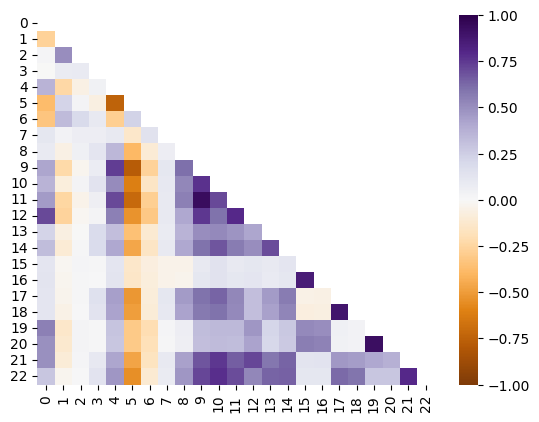

In [15]:
import seaborn as sb
import json
from python_proj.utils.util import SafeDict

tick_labels = list(range(len(vif_df)))
corr = tested_predictors.corr(method='spearman')
rows, cols = corr.shape
mask = np.invert(np.tril(np.ones((rows, cols), dtype=bool), k=-1))
dataplot = sb.heatmap(corr, cmap="PuOr",
                      xticklabels=tick_labels, yticklabels=tick_labels,
                      mask=mask,
                      vmin=-1, vmax=1)


def get_correlating_fields(coof_threshold, corr):
    print(f'{coof_threshold=}')
    correlating_fields = []
    # print(corr)
    for rowIndex, row in corr.iterrows():  # iterate over rows
        for columnIndex, coof in row.items():
            if columnIndex <= rowIndex:
                continue
            if abs(coof) < coof_threshold:
                continue
            correlating_fields.append([columnIndex, rowIndex, coof])
    correlating_fields = [list(entry) for entry in correlating_fields]
    print("Correlating pairs:\n" + json.dumps(correlating_fields, indent=4) + "\n")
    return correlating_fields


correlating_fields = get_correlating_fields(coof_threshold=0.5, corr=corr)

# Identify problematic fields:
presence_counts = SafeDict(default_value=0)
for (field_a, field_b, _) in correlating_fields:
    presence_counts[field_a] += 1
    presence_counts[field_b] += 1
pc = list(presence_counts.items())
pc.sort(key=lambda x: x[1])
# print(f'Variable correlation frequency:\n{json.dumps(pc, indent=4)}\n')

# Generate transitive closures


def unify_if_overlapping(collections: list[list]):
    # gather the lists that do overlap
    overlapping = [x for x in collections if
                   any(x_element in [y for k in collections
                                     if k != x for y in k]
                       for x_element in x)]
    # flatten and get unique
    overlapping = sorted(list(set([z for x in overlapping for z in x])))
    # get the rest
    non_overlapping = [x for x in collections if all(
        y not in overlapping for y in x)]
    # use the line bellow only if merged non-overlapping elements are desired
    # non_overlapping = sorted([y for x in non_overlapping for y in x])
    non_overlapping.append(overlapping)
    return non_overlapping


correlating_no_coof = [(a, b) for (a, b, _) in correlating_fields]
unified = unify_if_overlapping(correlating_no_coof)
print("Transitive closure of correlating pairs:\n" +
      json.dumps(unified, indent=4))


Plots a graph when there are correlating fields.


[['ln(1 + IntraProjectSharedExperiencePullRequestSubmittedByIntegratorIntegratedBySubmitter)', 'ControlIntegratedBySameUser', 0.7046834782307828], ['ln(1 + EcosystemIntegratorToSubmitterLinkIntensity)', 'ControlIntegratedBySameUser', 0.5522007977417791], ['ControlPullRequestHasComments', 'ControlPullRequestHasCommentByExternalUser', 0.5020571980953928], ['SubmitterIsFirstTimeContributor', 'IntraProjectSubmitterPullRequestSuccessRate', -0.7447582968582138], ['ln(1 + IntraProjectSubmitterPullRequestSubmissionCount)', 'IntraProjectSubmitterPullRequestSuccessRate', 0.7363084770593176], ['ln(1 + IntraProjectSubmitterPullRequestCommentCount)', 'IntraProjectSubmitterPullRequestSuccessRate', 0.5119667222027553], ['ln(1 + IntraProjectSharedExperiencePullRequestSubmittedBySubmitterIntegratedByIntegrator)', 'IntraProjectSubmitterPullRequestSuccessRate', 0.7034874984305897], ['ln(1 + IntraProjectSharedExperiencePullRequestSubmittedByIntegratorIntegratedBySubmitter)', 'IntraProjectSubmitterPullRequ

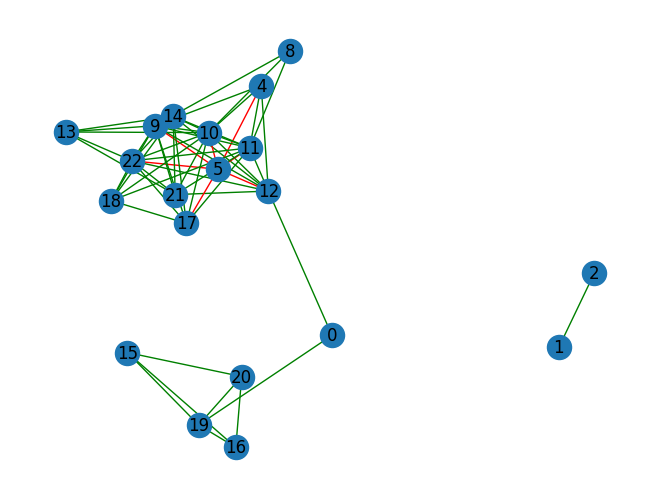

In [16]:
import networkx as nx
import matplotlib.pyplot as plt

if len(correlating_fields) > 0:
    fields = list(tested_predictors.columns)
    enumerated_list = list(enumerate(fields))
    ids = []
    edge_colors = {}
    print(correlating_fields)
    for (source, target, coof) in correlating_fields:
        source_idx = fields.index(source)
        target_idx = fields.index(target)
        ids.append((source_idx, target_idx))
        edge_color = 'red' if coof < 0.0 else 'green'
        edge_colors[(source_idx, target_idx)] = edge_color
        edge_colors[(target_idx, source_idx)] = edge_color


    # Create an empty graph
    graph = nx.Graph()

    # Add edges to the graph from the list of tuples
    graph.add_edges_from(ids)
    edge_colors = [edge_colors[(source_idx, target_idx)] for source_idx, target_idx in graph.edges()]

    pos = nx.spring_layout(graph, k=0.8)
    nx.draw(graph, pos, with_labels=True, edge_color=edge_colors)

    output_path = f'{figure_base_path}/correlating_fields.png'
    safe_save_fig(output_path)

    print(json.dumps(enumerated_list))

    with open(f'{figure_base_path}/correlating_fields_legend.txt', "w+", encoding='utf-8') as output_file:
        output_file.write(json.dumps(enumerated_list, indent=4))


In [17]:
print(f'{len(tested_predictors.columns)=}')
print(f'{tested_predictors.columns=}')


len(tested_predictors.columns)=23
tested_predictors.columns=Index(['ControlIntegratedBySameUser', 'ControlPullRequestHasComments',
       'ControlPullRequestHasCommentByExternalUser',
       'ControlHasHashTagInDescription',
       'IntraProjectSubmitterPullRequestSuccessRate',
       'SubmitterIsFirstTimeContributor',
       'ln(1 + ControlPullRequestLifeTimeInMinutes)',
       'ln(1 + ControlNumberOfCommitsInPullRequest)',
       'ln(1 + ControlIntraProjectPullRequestExperienceOfIntegrator)',
       'ln(1 + IntraProjectSubmitterPullRequestSubmissionCount)',
       'ln(1 + IntraProjectSubmitterPullRequestCommentCount)',
       'ln(1 + IntraProjectSharedExperiencePullRequestSubmittedBySubmitterIntegratedByIntegrator)',
       'ln(1 + IntraProjectSharedExperiencePullRequestSubmittedByIntegratorIntegratedBySubmitter)',
       'ln(1 + IntraProjectSubmitterIssueSubmissionCount)',
       'ln(1 + IntraProjectSubmitterIssueCommentCount)',
       'ln(1 + WeightedEcosystemSecondOrderInDegreeCen

## Outliers

Using cook's distance.


In [18]:
import statsmodels.api as sm
import scipy

X_constant = sm.add_constant(tested_predictors)

# Use GLM method for logreg here so that we can retrieve the influence measures
logit_results = sm.GLM(df[pr_merged_key], X_constant,
                       family=sm.families.Binomial()).fit()

# Get influence measures
influence = logit_results.get_influence()

# Obtain summary df of influence measures
summ_df = influence.summary_frame()

# Filter summary df to Cook's distance values only
diagnosis_df = summ_df[['cooks_d']]

# Set Cook's distance threshold
cook_threshold = 4 / len(tested_predictors)

# Append absolute standardized residual values
diagnosis_df['std_resid'] = scipy.stats.zscore(logit_results.resid_pearson)
diagnosis_df['std_resid'] = diagnosis_df['std_resid'].apply(
    lambda x: np.abs(x))

# Find observations which are BOTH outlier (std dev > 3) and highly influential
extreme = diagnosis_df[(diagnosis_df['cooks_d'] > cook_threshold) &
                       (diagnosis_df['std_resid'] > 3)]


# Show top 5 highly influential outlier observations
extreme.sort_values("cooks_d", ascending=False).head(10)


/tmp/ipykernel_76169/2490181039.py:23: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  diagnosis_df['std_resid'] = scipy.stats.zscore(logit_results.resid_pearson)
/tmp/ipykernel_76169/2490181039.py:24: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  diagnosis_df['std_resid'] = diagnosis_df['std_resid'].apply(


,cooks_d,std_resid
999367,0.000112,8.357902
369328,0.000109,4.858677
558064,0.000104,6.206985
502622,0.000103,4.319769
924335,0.000102,4.846775
889037,0.000087,6.920076
847705,0.000085,4.251072
1071087,0.000082,4.645400
762660,0.000079,4.618398
1012555,0.000077,6.576766


3.2889408541543846e-06
Found outliers: 21409 / 1216221 (1.760%)


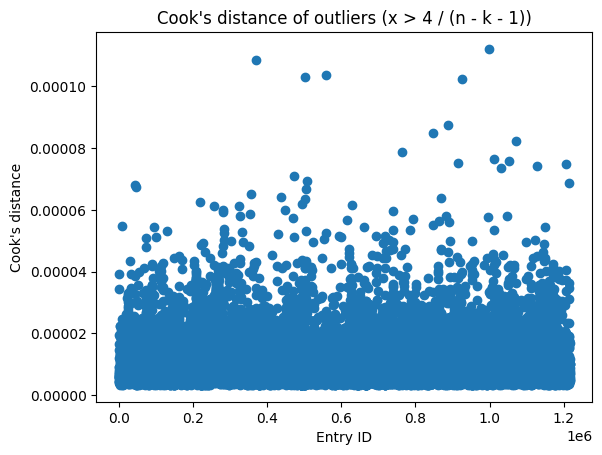

In [19]:
cook_threshold = 4 / (len(tested_predictors) -
                      len(tested_predictors.columns) - 1)
print(cook_threshold)
print(
    f'Found outliers: {len(extreme)} / {len(tested_predictors)} ({100 * len(extreme)/len(tested_predictors):.03f}%)')

plt.title("Cook's distance of outliers (x > 4 / (n - k - 1))")
plt.scatter(extreme.index, extreme['cooks_d'])
plt.xlabel("Entry ID")
plt.ylabel("Cook's distance")

output_path = f'{figure_base_path}/cooks_outliers.png'
safe_save_fig(output_path)


Removes outliers

In [20]:
tested_predictors = tested_predictors.drop(extreme.index)
tested_dependents = dependent.drop(extreme.index)

print(f'{len(tested_predictors)=}')

len(tested_predictors)=1194812


# Model Creation

Creates a simple mixed effect logistic regression model.

In [21]:
from statsmodels.regression.mixed_linear_model import MixedLM

# Selects relevant project names.
pn_key = "Project Name"
tested_projects = df[pn_key].copy()
tested_projects = tested_projects[tested_predictors.index]

# Creates model.
mixed_model = MixedLM(
    tested_dependents,
    tested_predictors,
    tested_projects,
).fit()

mixed_model.summary()


<class 'statsmodels.iolib.summary2.Summary'>
"""
                                                Mixed Linear Model Regression Results
======================================================================================================================================
Model:                                   MixedLM                        Dependent Variable:                        PullRequestIsMerged
No. Observations:                        1194812                        Method:                                    REML               
No. Groups:                              20052                          Scale:                                     0.0920             
Min. group size:                         1                              Log-Likelihood:                            -324157.8369       
Max. group size:                         688                            Converged:                                 Yes                
Mean group size:                         59.6                                                                                         
--------------------------------------------------------------------------------------------------------------------------------------
                                                                                          Coef.  Std.Err.    z     P>|z| [0.025 0.975]
--------------------------------------------------------------------------------------------------------------------------------------
ControlIntegratedBySameUser                                                               -0.308    0.001 -316.307 0.000 -0.310 -0.306
ControlPullRequestHasComments                                                             -0.105    0.001 -133.544 0.000 -0.107 -0.104
ControlPullRequestHasCommentByExternalUser                                                 0.021    0.001   24.991 0.000  0.019  0.022
ControlHasHashTagInDescription                                                             0.023    0.001   35.143 0.000  0.022  0.025
IntraProjectSubmitterPullRequestSuccessRate                                                0.203    0.001  168.380 0.000  0.200  0.205
SubmitterIsFirstTimeContributor                                                           -0.017    0.001  -16.356 0.000 -0.019 -0.015
ln(1 + ControlPullRequestLifeTimeInMinutes)                                               -0.368    0.002 -236.326 0.000 -0.371 -0.365
ln(1 + ControlNumberOfCommitsInPullRequest)                                                0.151    0.004   34.972 0.000  0.142  0.159
ln(1 + ControlIntraProjectPullRequestExperienceOfIntegrator)                               1.069    0.003  325.632 0.000  1.063  1.076
ln(1 + IntraProjectSubmitterPullRequestSubmissionCount)                                   -1.078    0.006 -170.664 0.000 -1.091 -1.066
ln(1 + IntraProjectSubmitterPullRequestCommentCount)                                       0.257    0.004   65.961 0.000  0.249  0.264
ln(1 + IntraProjectSharedExperiencePullRequestSubmittedBySubmitterIntegratedByIntegrator)  0.307    0.006   47.712 0.000  0.295  0.320
ln(1 + IntraProjectSharedExperiencePullRequestSubmittedByIntegratorIntegratedBySubmitter)  0.517    0.005  100.707 0.000  0.507  0.527
ln(1 + IntraProjectSubmitterIssueSubmissionCount)                                         -0.123    0.004  -29.633 0.000 -0.132 -0.115
ln(1 + IntraProjectSubmitterIssueCommentCount)                                             0.269    0.003   84.096 0.000  0.263  0.275
ln(1 + WeightedEcosystemSecondOrderInDegreeCentrality)                                     0.109    0.006   19.112 0.000  0.098  0.120
ln(1 + WeightedEcosystemSecondOrderOutDegreeCentrality)                                    0.055    0.006    9.121 0.000  0.043  0.067
ln(1 + WeightedIntraProjectSecondOrderInDegreeCentrality)                                 -0.081    0.006  -13.140 0.000 -0.093 -0.069
ln(1 + WeightedIntraProjectSecondOrderOutDegreeCentrality)                           

###

In [22]:
import os

# outputs results to a csv.

summ = mixed_model.summary()

fields = summ.tables[1]
output = pd.DataFrame()
for field in fields.columns:
    output[f'Dependency Model: {field}'] = fields[field]

print(output)
dir_name = f'{base_path}/coefs/{file_name}/'
output_path = f'{dir_name}/coefs.csv'
if not os.path.exists(dir_name):
    os.makedirs(dir_name)
output.to_csv(output_path)


                                                   Dependency Model: Coef.   
ControlIntegratedBySameUser                                         -0.308  \
ControlPullRequestHasComments                                       -0.105   
ControlPullRequestHasCommentByExternalUser                           0.021   
ControlHasHashTagInDescription                                       0.023   
IntraProjectSubmitterPullRequestSuccessRate                          0.203   
SubmitterIsFirstTimeContributor                                     -0.017   
ln(1 + ControlPullRequestLifeTimeInMinutes)                         -0.368   
ln(1 + ControlNumberOfCommitsInPullRequest)                          0.151   
ln(1 + ControlIntraProjectPullRequestExperience...                   1.069   
ln(1 + IntraProjectSubmitterPullRequestSubmissi...                  -1.078   
ln(1 + IntraProjectSubmitterPullRequestCommentC...                   0.257   
ln(1 + IntraProjectSharedExperiencePullRequestS...              

In [23]:
import datetime

print(datetime.datetime.now())

2024-02-16 16:11:32.009825
